In [318]:
from transformers import BertTokenizer, BertModel
from torch import nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Example of tokenization

You must convert text to tokens before inputting it into BERT. 

In [319]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

example_text = "Hello world"

token_res = tokenizer(example_text, return_tensors='pt')

print(token_res['input_ids']) ## vector of token IDs
print(token_res['attention_mask']) ## vector of 0/1 to indicate real tokens vs padding tokens

out_text = tokenizer.decode(token_res['input_ids'][0])
print(out_text)

tensor([[ 101, 7592, 2088,  102]])
tensor([[1, 1, 1, 1]])
[CLS] hello world [SEP]


### Wine dataset

Dataset has 120K wines. We focus on the variables *description* and *price*.

(120975, 14)
Description:  This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
Price:  15.0
Description:  Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.
Price:  14.0
Description:  Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.
Price:  13.0
Most expensive wine:  This ripe wine shows plenty of blackberry fruits balanced well with some dry tannins. It is fresh, juicy with plenty of acidity, For a light vintage, it's perfumed, full of fresh flavors and will be ready to drink from 2017.
Price:  3300.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9b18ae5300>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9b18ae5840>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9b18ae5060>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b18ae5d80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b18ae6020>],
 'means': []}

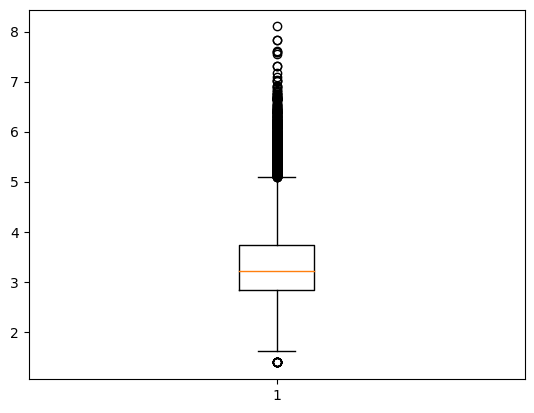

In [352]:
wine_df = pd.read_csv("wines.csv")

## keep only wines whose price is not NaN
wine_df = wine_df[wine_df['price'].notna()]

print(wine_df.shape)

## key variables: price, description
for i in range(3):
    print("Description: ", wine_df['description'].iloc[i])
    print("Price: ", wine_df['price'].iloc[i])

## find the wine with the highest price
max_price_idx = wine_df['price'].argmax()
print("Most expensive wine: ", wine_df['description'].iloc[max_price_idx])
print("Price: ", wine_df['price'].iloc[max_price_idx])

## make box-plot of prices
plt.boxplot(np.log(wine_df['price']))


In [353]:
class textClassDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        description = self.df.iloc[idx]['description']
        price = self.df.iloc[idx]['price']
        price = torch.tensor(price, dtype=torch.float32)
        encoded_text = self.tokenizer(description, return_tensors='pt', max_length=self.max_len, 
                                      padding='max_length', truncation=True)
        return encoded_text, price


In [332]:
dataset = textClassDataset(wine_df, tokenizer, 128)

## split into train and test datasets
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("training data size: " + str(len(train_dataset)))

## create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

training data size: 60487


In [333]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        ## for bert-base-uncased, hidden_size is 768
        self.layer1 = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs[1]

        x = self.layer1(pooled_output)
        x = x.squeeze(1)
        return x
    

In [334]:
model = BertRegressor()

## IMPORTANT:
## freeze bert parameters so that we only update the
## prediction head
for param in model.bert.parameters():
    param.requires_grad = False

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=1e-3)

num_epochs = 1

model.train()
it = 0


## Training

* Even 1 epoch of training takes about 2 hours.
* It takes time for BERT to process each tokenized sentence.
* You can skip the training to directly load from the saved model parameter file.

In [335]:
for epoch in range(num_epochs):

    for batch in train_dataloader:

        input_ids = batch[0]['input_ids'].squeeze(1)
        attention_mask = batch[0]['attention_mask']
        logprice = np.log(batch[1])

        pred = model(input_ids, attention_mask)
        loss = loss_fn(pred, logprice)
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        
        it = it + 1
        if (it % 1000 == 0):
            print("sgd iter: " + str(it))
    print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

sgd iter: 1000
sgd iter: 2000
sgd iter: 3000
sgd iter: 4000
sgd iter: 5000
sgd iter: 6000
Epoch: 0, Loss: 0.3123812675476074


In [375]:
## save model parameters
torch.save(model.state_dict(), "fine-tuned-bert.pt")

In [376]:
## load model
model.load_state_dict(torch.load("fine-tuned-bert.pt"))

<All keys matched successfully>

In [354]:
## calculate testing error
## takes about 2 minutes to run

model.eval()
mse = 0

n_test = 600

y_test = np.array([np.log(test_dataset[i][1]) for i in range(n_test)])

for i in range(n_test):
    pred = model(test_dataset[i][0]['input_ids'], test_dataset[i][0]['attention_mask'])
    mse = mse + (pred - y_test[i])**2

mse = mse / n_test

print("MSE:", mse.item(), "  Test R-squared:", 1 - mse.item() / np.var(y_test))

MSE: 0.3721877336502075   Test R-squared: 0.15866295258618945


In [374]:
## 

my_reviews = ["This white is both sour and bitter; it has a funny smell",
                "the most amazing wine I have ever tasted",
                "not bad at all; I would buy it again",
                "actually quite bad; avoid if possible",
                "great red and pretty cheap",
                "great red but overpriced",
                "great red and great price"]

for my_review in my_reviews:

    token_res = tokenizer(my_review, return_tensors='pt')

    pred = model(token_res['input_ids'], token_res['attention_mask'])
    
    print("My Description:", my_review)
    print("Predicted price: ", torch.exp(pred).item(), '\n')

My Description: This white is both sour and bitter; it has a funny smell
Predicted price:  11.787423133850098 

My Description: the most amazing wine I have ever tasted
Predicted price:  21.10090446472168 

My Description: not bad at all; I would buy it again
Predicted price:  15.844284057617188 

My Description: actually quite bad; avoid if possible
Predicted price:  11.518692016601562 

My Description: great red and pretty cheap
Predicted price:  11.09788703918457 

My Description: great red but overpriced
Predicted price:  18.13567543029785 

My Description: great red and great price
Predicted price:  19.601572036743164 



### Some useful resources for learning BERT
- https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
- https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b
- https://colab.research.google.com/drive/1pxc-ehTtnVM72-NViET_D2ZqOlpOi2LH?usp=sharing#scrollTo=SH_MAK-soD4F

